# Polish companies bankruptcy data
## https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data
Датасет содержит финансовые данные о польских компаниях, собранные с Emerging Markets Information Service (EMIS). Задача: предсказать банкротство компании.

In [1]:
import warnings
warnings.filterwarnings('ignore')
# базовые импорты
import pandas as pd
import numpy as np
import sklearn as skl
import xgboost as xgb
import seaborn as sb
import matplotlib.pyplot as plt
import subprocess


Bad key "text.kerning_factor" on line 4 in
/home/jekyll/miniconda3/envs/idp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# ускоряем часть sklearn при помощи патчинга daal4py
try:
    from daal4py.sklearn import patch_sklearn
    patch_sklearn()
except:
    pass

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [3]:
# # загрузка датасета
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip
# !unzip data.zip

### Чтение и получение основных хар-к

In [4]:
# получаем список файлов датасета
r = subprocess.run(['ls'], stdout=subprocess.PIPE)
all_files = str(r.stdout, encoding='utf-8')[:-1].split('\n')
data_files = []
for el in all_files:
    if el.endswith('.arff'):
        data_files.append(el)
print("Dataset files:", data_files)

Dataset files: ['1year.arff', '2year.arff', '3year.arff', '4year.arff', '5year.arff']


Датасет состоит из пяти файлов:
- 1year.arff содержит финансовые данные первого года из периода наблюдения и соотвествующих меток класса, которые сообщают о статусе банкротства через 5 лет (0 - компания продолжила работать, 1 - обанкротилась).
- 2year.arff содержит данные второго года и статус банкротства через 4 года
- 3year.arff содержит данные третьего года и статус банкротства через 3 года
- и т.д.

Файлы можно читать как обычный CSV, пропустив первые 69 строк.

В этом ноутбуке будет использоваться файл 3year.arff.

Описания/имена колонок были скопированы с описания датасета: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [5]:
columns = '''X1 net profit / total assets
X2 total liabilities / total assets
X3 working capital / total assets
X4 current assets / short-term liabilities
X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
X6 retained earnings / total assets
X7 EBIT / total assets
X8 book value of equity / total liabilities
X9 sales / total assets
X10 equity / total assets
X11 (gross profit + extraordinary items + financial expenses) / total assets
X12 gross profit / short-term liabilities
X13 (gross profit + depreciation) / sales
X14 (gross profit + interest) / total assets
X15 (total liabilities * 365) / (gross profit + depreciation)
X16 (gross profit + depreciation) / total liabilities
X17 total assets / total liabilities
X18 gross profit / total assets
X19 gross profit / sales
X20 (inventory * 365) / sales
X21 sales (n) / sales (n-1)
X22 profit on operating activities / total assets
X23 net profit / sales
X24 gross profit (in 3 years) / total assets
X25 (equity - share capital) / total assets
X26 (net profit + depreciation) / total liabilities
X27 profit on operating activities / financial expenses
X28 working capital / fixed assets
X29 logarithm of total assets
X30 (total liabilities - cash) / sales
X31 (gross profit + interest) / sales
X32 (current liabilities * 365) / cost of products sold
X33 operating expenses / short-term liabilities
X34 operating expenses / total liabilities
X35 profit on sales / total assets
X36 total sales / total assets
X37 (current assets - inventories) / long-term liabilities
X38 constant capital / total assets
X39 profit on sales / sales
X40 (current assets - inventory - receivables) / short-term liabilities
X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
X42 profit on operating activities / sales
X43 rotation receivables + inventory turnover in days
X44 (receivables * 365) / sales
X45 net profit / inventory
X46 (current assets - inventory) / short-term liabilities
X47 (inventory * 365) / cost of products sold
X48 EBITDA (profit on operating activities - depreciation) / total assets
X49 EBITDA (profit on operating activities - depreciation) / sales
X50 current assets / total liabilities
X51 short-term liabilities / total assets
X52 (short-term liabilities * 365) / cost of products sold)
X53 equity / fixed assets
X54 constant capital / fixed assets
X55 working capital
X56 (sales - cost of products sold) / sales
X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
X58 total costs / total sales
X59 long-term liabilities / equity
X60 sales / inventory
X61 sales / receivables
X62 (short-term liabilities *365) / sales
X63 sales / short-term liabilities
X64 sales / fixed assets'''

# создание листа фич
columns = [el[(3 + int(i >= 9)):] for i, el in enumerate(columns.split('\n'))] + ['bankruptcy']

In [6]:
# чтение данных
original_data = pd.read_csv(
    data_files[2], skiprows=69, header=None,
    names=columns, na_values='?', dtype=np.float64
)
original_data[['bankruptcy']] = original_data[['bankruptcy']].astype(np.int32)
print('Data shape:', original_data.shape)

Data shape: (10503, 65)


Большинство фич датасета является отношением каких-либо двух финансовых показателей, исключениями являются logarithm of total assets (логарифм от общих активов) и working capital.

In [7]:
# описание первых двадцати фич
original_data.describe().T[:20]

,count,mean,std,min,25%,50%,75%,max
net profit / total assets,10503.0,0.052844,0.647797,-1.769200e+01,0.000686,0.043034,0.123805,5.265200e+01
total liabilities / total assets,10503.0,0.619911,6.427041,0.000000e+00,0.253955,0.464140,0.689330,4.807300e+02
working capital / total assets,10503.0,0.095490,6.420056,-4.797300e+02,0.017461,0.198560,0.419545,1.770800e+01
current assets / short-term liabilities,10485.0,9.980499,523.691951,2.080200e-03,1.040100,1.605600,2.959500,5.343300e+04
[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,10478.0,-1347.662372,118580.569222,-1.190300e+07,-52.070750,1.579300,56.084000,6.854400e+05
retained earnings / total assets,10503.0,-0.121159,6.970625,-5.081200e+02,0.000000,0.000000,0.072584,4.553300e+01
EBIT / total assets,10503.0,0.065624,0.651152,-1.769200e+01,0.002118,0.050945,0.142275,5.265200e+01
book value of equity / total liabilities,10489.0,19.140113,717.756745,-2.081800e+00,0.431270,1.111000,2.857100,5.343200e+04
sales / total assets,10500.0,1.819254,7.581659,-1.215700e+00,1.011275,1.199000,2.059100,7.404400e+02
equity / total assets,10503.0,0.366093,6.428603,-4.797300e+02,0.297340,0.515500,0.725635,1.183700e+01


Наблюдается большой дисбаланс между классами 

In [8]:
def count_classes(data_frame):
    cls_counts = data_frame[['bankruptcy']].value_counts()
    print(cls_counts)
    print('Процент обанкротившихся компаний: {}%'.format(round(int(cls_counts[1]) / (sum(cls_counts)) * 100, 2)))

count_classes(original_data)

bankruptcy
0             10008
1               495
dtype: int64
Процент обанкротившихся компаний: 4.71%


Построим матрицу корреляции, но только для двадцати фич, у которых сумма квадратов корреляции максимальна, т.к. все 64 не влезут в рисунок.
В основном, коррелируют только пары фич, которые связаны общими фин. показателями в отношении.

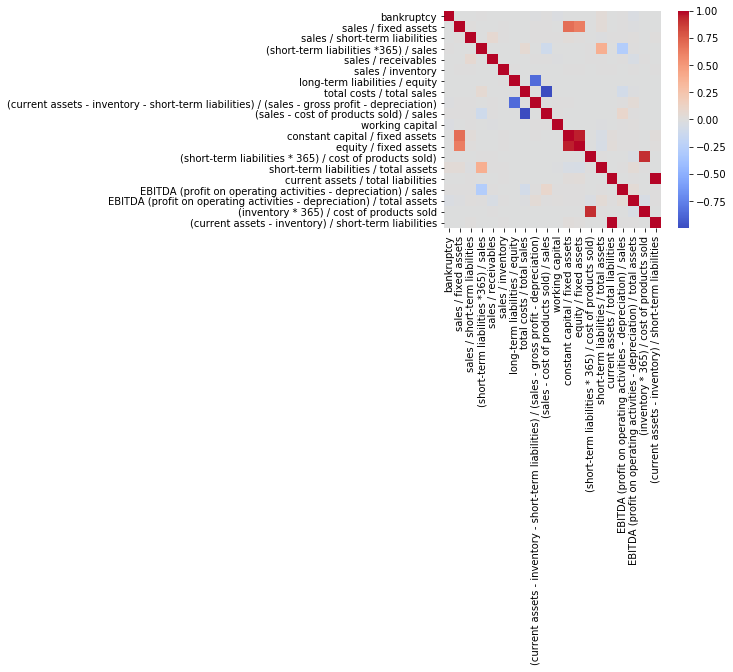

In [9]:
# будем исключать корреляции пар фич, которые базируются на хотя бы одном одинаковом фин. показателе
def cols_has_same_fin_rate(col_1, col_2):
    col_1, col_2 = set(col_1.split(' / ')), set(col_2.split(' / '))
    if len(col_1.union(col_2)) > 0:
        return True
    else:
        return False


def build_corr_matrix(data_frame):
    corr_matrix = data_frame.corr()
    corr_sums = {}
    for col_i in list(data_frame.columns):
        corr_sum = 0
        for col_j in list(data_frame.columns):
            if col_i == col_j or cols_has_same_fin_rate(col_i, col_j):
                continue
            corr_sum += corr_matrix[col_j][col_i] ** 2
        corr_sums.update({col_i: corr_sum})
    corr_sums = dict(sorted(corr_sums.items(), key=lambda x: x[1])[::-1])
    selected_features = list(corr_sums.keys())[:20]
    sb.heatmap(corr_matrix.loc[selected_features, selected_features], square=True, cmap='coolwarm')


build_corr_matrix(original_data)

В датасете присутствуют NaN'ы, причем в некоторых фичах их кол-во доходит почти до половины от всех значений.

In [10]:
def print_df_nan_counts(data_frame):
    print([sum(data_frame[col].isna()) for col in list(data_frame.columns)])

def print_df_inf_cols(data_frame, verbose=False):
    infc_all = 0
    for col in list(data_frame.columns):
        inf_count = (data_frame[col] == np.inf).mean()
        if inf_count > 0:
            infc_all += 1
            if verbose:
                print(col, inf_count)
    print(infc_all)

print('NaN count in features:')
print_df_nan_counts(original_data)
print('Number of features with Inf:')
print_df_inf_cols(original_data)

NaN count in features:
[0, 0, 0, 18, 25, 0, 0, 14, 3, 0, 0, 18, 43, 0, 8, 14, 14, 0, 43, 43, 807, 0, 43, 227, 0, 14, 715, 228, 0, 43, 43, 101, 18, 14, 0, 0, 4736, 0, 43, 18, 202, 43, 43, 43, 591, 18, 86, 0, 43, 14, 0, 86, 228, 228, 0, 43, 0, 29, 0, 592, 17, 43, 18, 228, 0]
Number of features with Inf:
0


Заполняем NaN'ы медианами

In [11]:
preproc_data = original_data.copy()

def fill_nan_inf(data_frame, nan=True, inf=False):
    if nan:
        data_frame.fillna(data_frame.median(axis=0), axis=0, inplace=True)
    if inf:
        for col in list(data_frame.columns):
            data_frame[col] = data_frame[col].replace(np.inf, data_frame[col].median())

fill_nan_inf(preproc_data)

Удаляем выбросы по квантилям 0.0025 и 0.9975 для каждой фичи

In [12]:
def remove_outliers(data_frame, lower_bound=0.0025, upper_bound=0.9975, y_label=-1, y=None):
    if y_label == -1:
        cols = list(data_frame.columns)[:-1]
    else:
        cols = list(data_frame.columns)
    selection = [(data_frame[col] < data_frame[col].quantile(lower_bound)) \
                 | (data_frame[col] > data_frame[col].quantile(upper_bound)) for col in cols]
    rows_to_drop = selection[0]
    for sel in selection[1:]:
        rows_to_drop |= sel
    rows_to_drop = data_frame[rows_to_drop].index
    if y is None:
        return data_frame.drop(rows_to_drop)
    else:
        return data_frame.drop(rows_to_drop), y.drop(rows_to_drop)

print('Новый баланс классов:')
old_n_rows = preproc_data.shape[0]
preproc_data = remove_outliers(preproc_data)
count_classes(preproc_data)
print('\nПроцент потерянных строк: {}%'.format(round((old_n_rows - preproc_data.shape[0]) / old_n_rows * 100, 2)))

Новый баланс классов:
bankruptcy
0             9068
1              435
dtype: int64
Процент обанкротившихся компаний: 4.58%

Процент потерянных строк: 9.52%


Т.к. большинство признаков безразмерны, а для kNN c Евклидовой дистанцией лучше избавиться от большого разброса значений между фичами, проведем нормализацию.

In [13]:
y = preproc_data[['bankruptcy']]
preproc_data = preproc_data.drop(columns=['bankruptcy'])

def normalize_data(data_frame):
    return (data_frame - data_frame.mean(axis = 0)) / data_frame.std(axis = 0)

norm_data = normalize_data(preproc_data)

Разделим датасет на тренировочную и тестовую выборки.
Для оценки точности алгоритмов машинного обучения будем считать accuracy score, recall score, precision score

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score

def train_and_score(alg_instance, data_frame, y, test_size=0.33, not_print=False):
    x, y = data_frame, y
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, random_state=42)
    alg_instance.fit(train_x, train_y)
    pred_y = alg_instance.predict(test_x)
    test_y = test_y.to_numpy().ravel()
    accuracy = accuracy_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    accuracy, recall, precision = round(accuracy, 6), round(recall, 6), round(precision, 6)
    if not not_print:
        print('Accuracy score: {}'.format(accuracy))
        print('Recall score: {}'.format(recall))
        print('Precision score: {}'.format(precision))
    return accuracy, recall, precision

Как видно, kNN плохо подходит для решения задачи при любом кол-ве соседей

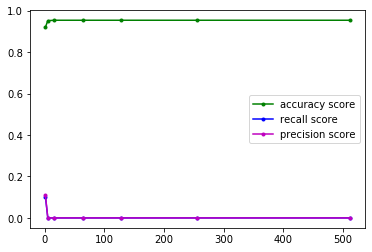

In [15]:
from sklearn.neighbors import KNeighborsClassifier

ks = [1, 5, 16, 64, 128, 256, 512]
scores = {'accuracy': [], 'recall': [], 'precision': []}
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy, recall, precision = train_and_score(knn, norm_data, y, not_print=True)
    scores['accuracy'].append(accuracy)
    scores['recall'].append(recall)
    scores['precision'].append(precision)

plt.plot(ks, scores['accuracy'], '.-m', label = 'accuracy score', color='green')
plt.plot(ks, scores['recall'], '.-m', label = 'recall score', color='blue')
plt.plot(ks, scores['precision'], '.-m', label = 'precision score')
plt.legend(loc = 'best')
plt.show()

Даже использование гораздо более сложных случайного леса и градиентного бустинга не дает хорошие результаты

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF()
gbt = xgb.XGBClassifier()

print('RandomForestClassifier results:')
train_and_score(rf, preproc_data, y)
print('')

print('GradientBoostingClassifier results:')
train_and_score(gbt, preproc_data, y)
print('')

RandomForestClassifier results:
Accuracy score: 0.955676
Recall score: 0.068493
Precision score: 0.769231

GradientBoostingClassifier results:
Accuracy score: 0.972258
Recall score: 0.431507
Precision score: 0.940299



## Little feature engineering or information gain

Для того, чтобы улучшить результаты, можно попробовать получить еще немного информации из исходных данных:

Если многие фичи являются отношениями фин. показателей, то можно из этих отношений получить новые, т.е. из a/b и c/b получить a/с.

In [17]:
def gen_new_columns(col1, col2):
    col1, col2 = col1.split(' / '), col2.split(' / ')
    if len(col1) != 2 or len(col2) != 2:
        return ''
    if col1[1] == col2[1]:
        return col1[0] + ' / ' + col2[0]
    return ''

ext_data = original_data.copy()

for i, el_i in enumerate(columns):
    for j, el_j in enumerate(columns):
        if i == j:
            continue
        new_col = gen_new_columns(el_i, el_j)
        if new_col != '':
            ext_data[new_col] = ext_data[el_i] / ext_data[el_j]

ext_data = remove_outliers(ext_data, lower_bound=0.0015, upper_bound=0.9985)
fill_nan_inf(ext_data, inf=True)
y_ext = ext_data[['bankruptcy']]
ext_data = ext_data.drop(columns=['bankruptcy'])
print()
print('Размер нового дата фрейма:', ext_data.shape)


Размер нового дата фрейма: (8960, 522)


Теперь результаты градиентного бустинга стали гораздо лучше

In [18]:
print('GradientBoostingClassifier results:')
train_and_score(gbt, ext_data, y_ext)

GradientBoostingClassifier results:
Accuracy score: 0.993236
Recall score: 0.893617
Precision score: 0.961832


(0.993236, 0.893617, 0.961832)

# Neural network

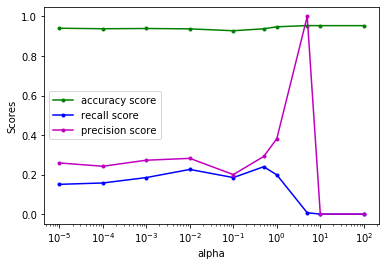

In [34]:
from sklearn.neural_network import MLPClassifier

alpha_arr = np.logspace(-4, 3, 21)
scores = {'accuracy': [], 'recall': [], 'precision': []}
for alpha in alphas:
    mlp = MLPClassifier(solver='lbfgs', activation = 'logistic', alpha=alpha,
                    hidden_layer_sizes=(12, 8), random_state=42)
    accuracy, recall, precision = train_and_score(mlp, norm_data, y, not_print=True)
    scores['accuracy'].append(accuracy)
    scores['recall'].append(recall)
    scores['precision'].append(precision)

plt.semilogx(alphas, scores['accuracy'], '.-m', label = 'accuracy score', color='green')
plt.semilogx(alphas, scores['recall'], '.-m', label = 'recall score', color='blue')
plt.semilogx(alphas, scores['precision'], '.-m', label = 'precision score')
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('Scores')
plt.show()

## PCA

Сократим размерность до двух признаков

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
new_data = pca.fit_transform(norm_data)

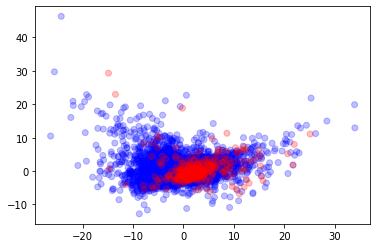

In [36]:
colors = ['r' if yy == 1 else 'b' for yy in y.values]
plt.scatter(new_data[:, 0], new_data[:, 1], color=colors, alpha=0.25)

SVM так же не является хорошим решение для задачи

In [37]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
train_and_score(svc, new_data, y)

Accuracy score: 0.953444
Recall score: 0.0
Precision score: 0.0


(0.953444, 0.0, 0.0)

Попробуем варьировать число компонент, при этом смотря на точность решения задачи градиентным бустингом

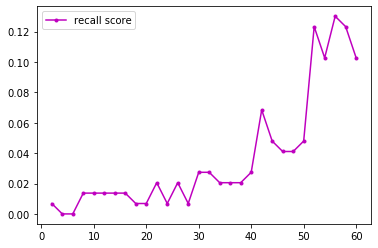

In [38]:
n_comps = list(range(2, norm_data.shape[1] - 2, 2))
false_negs = []
for nc in n_comps:
    pca = PCA(n_components=nc)
    new_data = pca.fit_transform(norm_data)
    accuracy, recall, precision = train_and_score(gbt, new_data, y, not_print=True)
    false_negs.append(recall)

plt.plot(n_comps, false_negs, '.-m', label = 'recall score')
plt.legend(loc = 'best')